In [49]:
library(tidyverse)
library(ggplot2)
library(factoextra)
library(reshape2)
library(umap)
library(ComplexHeatmap)
library(cluster)
library(dynamicTreeCut)
library(uwot)
library(RColorBrewer)
library(circlize)

In [50]:
load_dir <- "ARS313/plot_data"

In [51]:
methylation_rep1 <- read_csv(paste(load_dir, "/ARS313_violinplots_annotation_v3.csv", sep=""))
methylation_rep1 <- methylation_rep1[, -1]
methylation_rep1$feature <- factor(methylation_rep1$feature, levels = c("-3ns", "-2ns", "-2L", "-1ns", "-1L",
                                                                       "ARS313", "+1ns", "+2L", "+2ns", "+3ns"))
methylation_rep1$condition <- factor(methylation_rep1$condition)

New names:
* `` -> ...1

Rows: 87840 Columns: 5
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): feature, condition
dbl (3): ...1, molecule, norm methylation

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [52]:
colnames(methylation_rep1)[3] <- "norm_methylation"

In [53]:
methylation_long <- dcast(methylation_rep1, molecule + condition ~feature, value.var = "norm_methylation")

In [54]:
scaled_meth <- scale(methylation_long[,-(1:2)])

In [55]:
#define linkage methods
#m <- c( "average", "single", "complete", "ward")
#names(m) <- c( "average", "single", "complete", "ward")

#function to compute agglomerative coefficient
#ac <- function(x) {
#  agnes(scaled_meth, method = x)$ac
#}
#
#calculate agglomerative coefficient for each clustering linkage method
#sapply(m, ac)"""

In [196]:
pca_meth <- prcomp(scaled_meth)

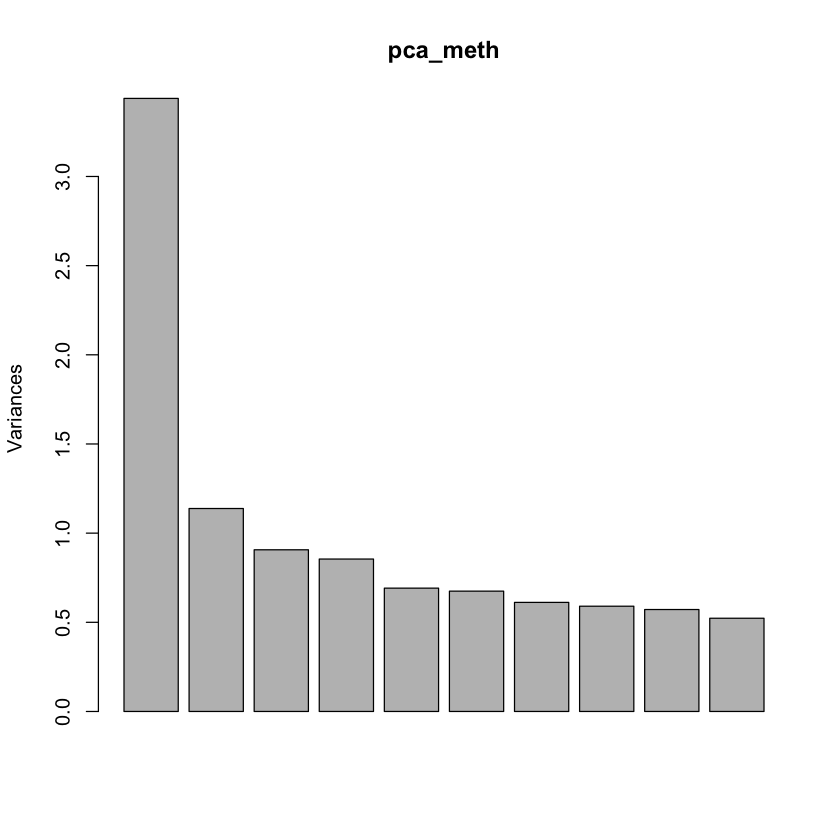

In [197]:
plot(pca_meth)

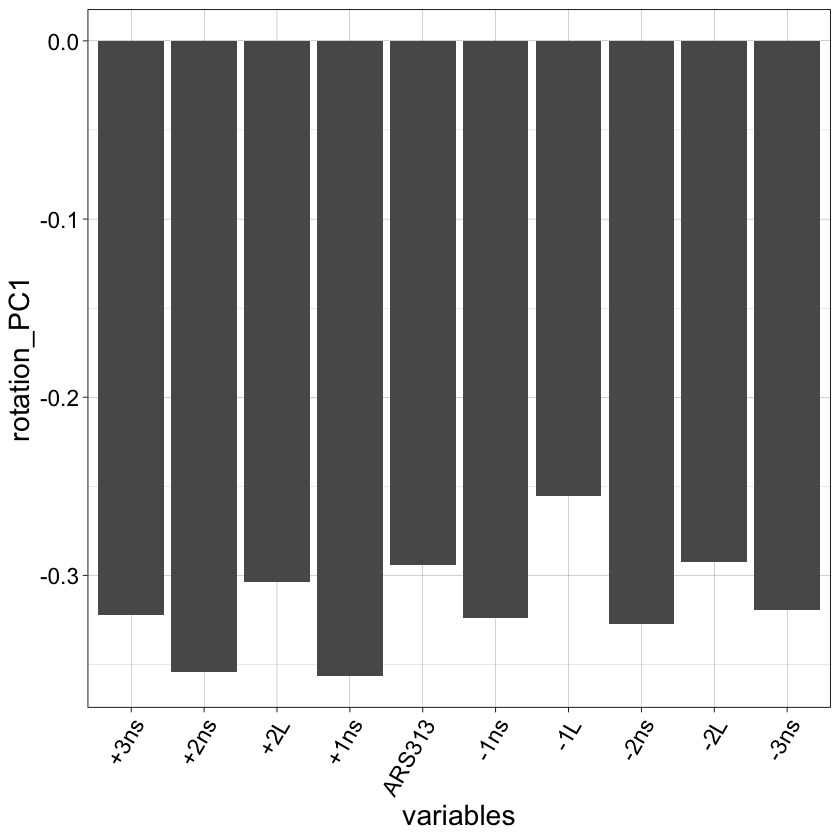

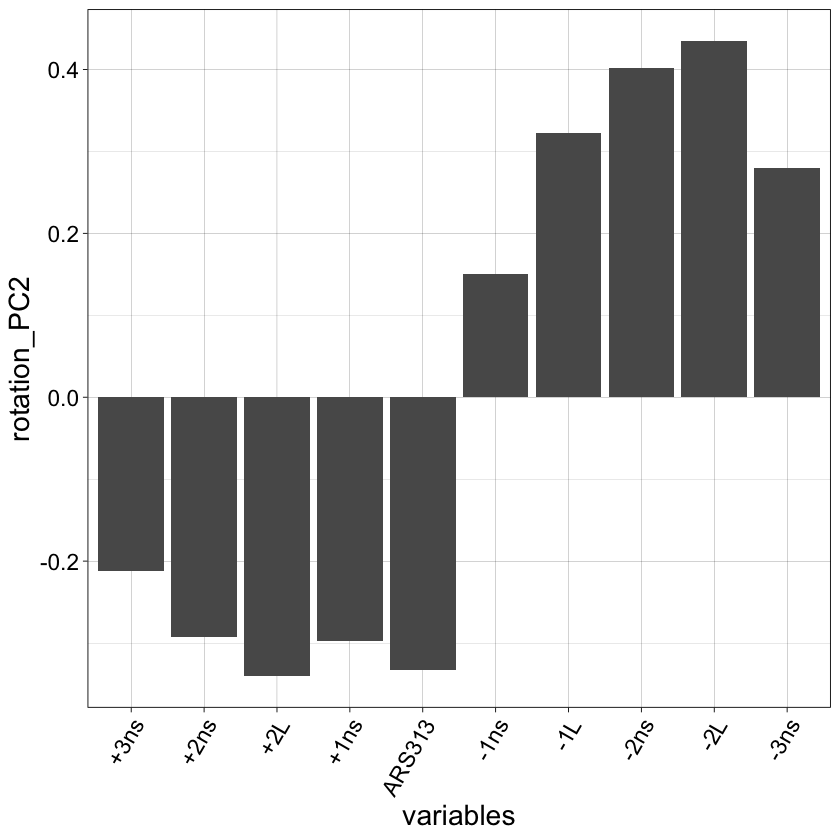

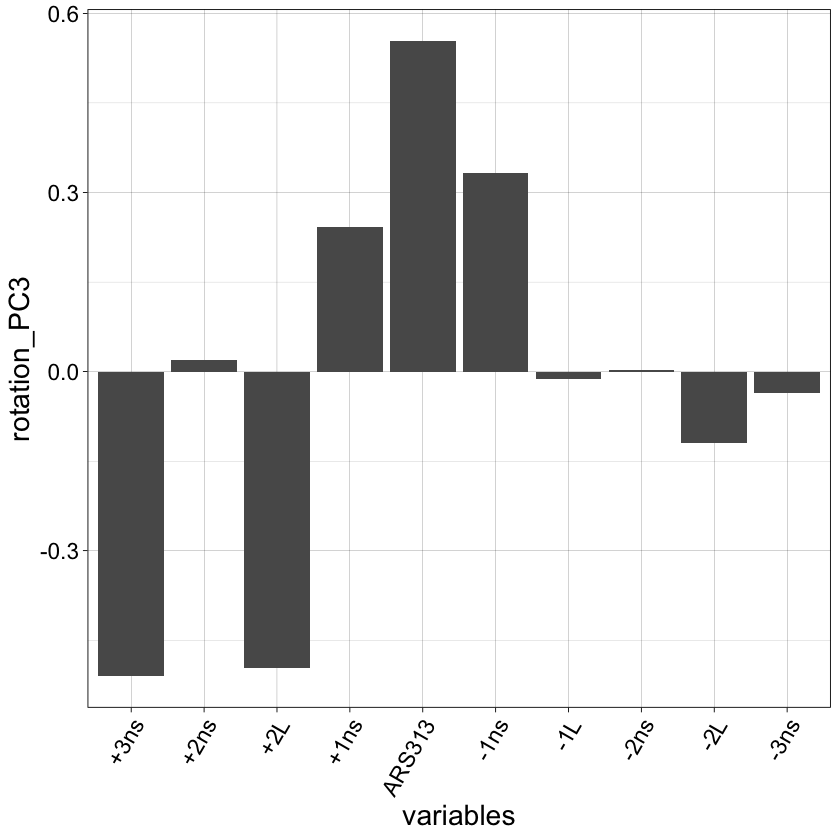

In [198]:
pca.summary <- summary(pca_meth)

df_plot <- data.frame("variables"= rownames(pca.summary$rotation),
                 "rotation_PC1" = pca.summary$rotation[,1],
                 "rotation_PC2" = pca.summary$rotation[,2],
                 "rotation_PC3" = pca.summary$rotation[,3])

df_plot$variables <- factor(df_plot$variables, levels = c("+3ns", "+2ns", "+2L", "+1ns", 
                                                          "ARS313", "-1ns", "-1L", "-2ns", "-2L", "-3ns"))

ggplot(df_plot) + theme_linedraw() +
  geom_col(aes(x= variables, y = rotation_PC1)) + 
  theme(text = element_text(size=17),
        axis.text.x = element_text(angle = 60, hjust=1))

ggplot(df_plot) + theme_linedraw() +
  geom_col(aes(x= variables, y = rotation_PC2)) + 
  theme(text = element_text(size=17),
        axis.text.x = element_text(angle = 60, hjust=1))

ggplot(df_plot) + theme_linedraw() +
  geom_col(aes(x= variables, y = rotation_PC3)) + 
  theme(text = element_text(size=17),
        axis.text.x = element_text(angle = 60, hjust=1))

In [56]:
clust <- agnes(scaled_meth, method = "ward")

In [57]:
clust$ac

[1] 0.9937979

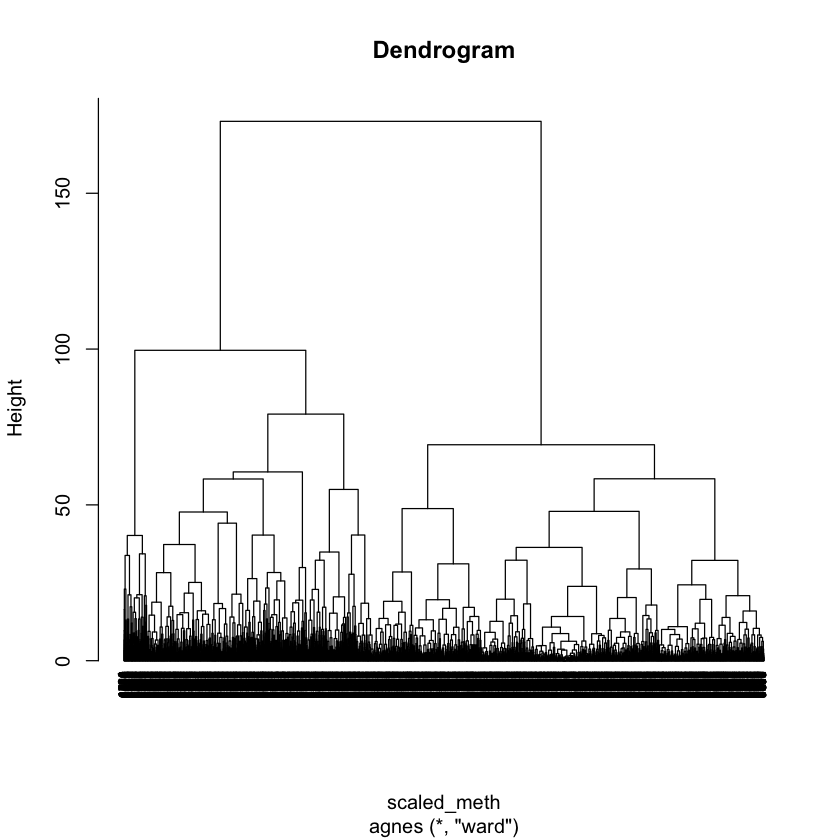

In [58]:
#produce dendrogram
pltree(clust, cex = 0.6, hang = -1, main = "Dendrogram")

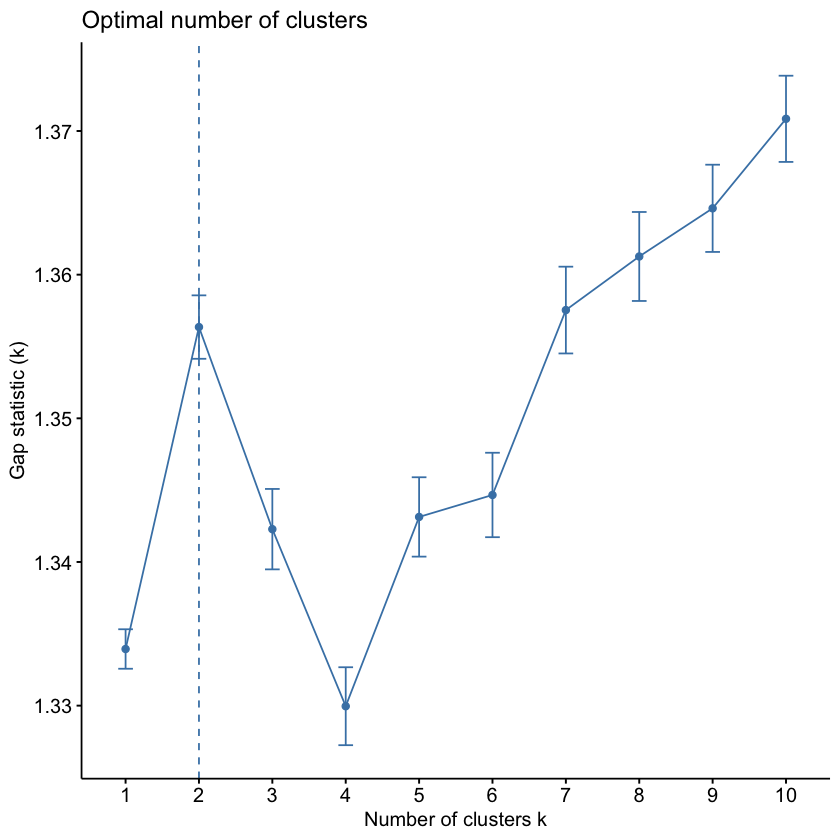

In [59]:
#This step is computationally very expensive. Avoid rerunning if possible (or run overnight)

#calculate gap statistic for each number of clusters (up to 10 clusters)
#gap_stat <- clusGap(scaled_meth, FUN = hcut, nstart = 25, K.max = 10, B = 50)

#produce plot of clusters vs. gap statistic
#fviz_gap_stat(gap_stat)

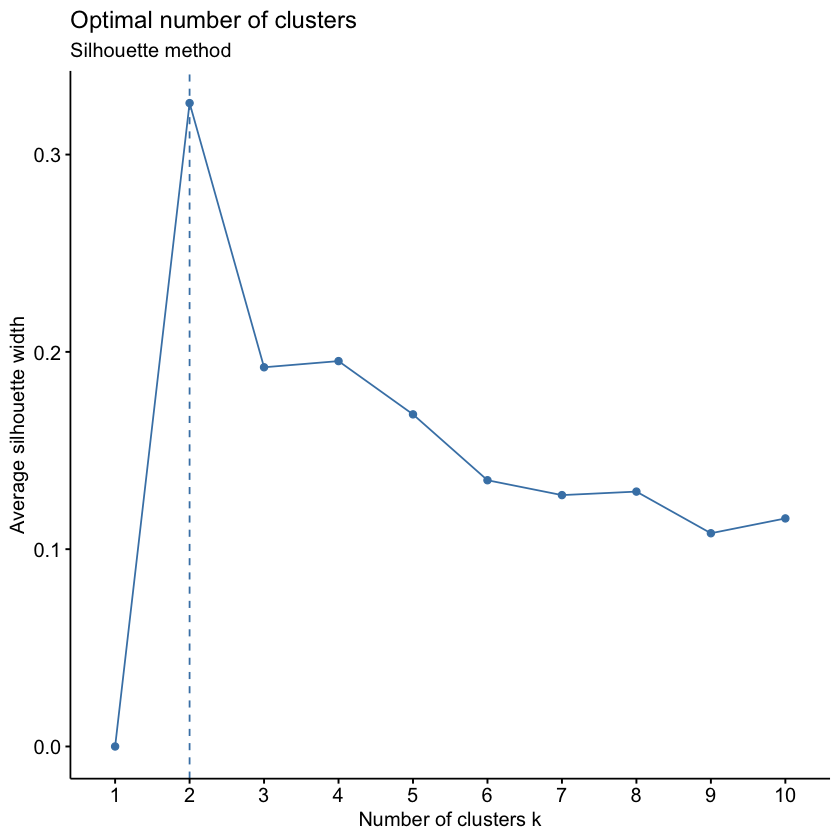

In [60]:
fviz_nbclust(scaled_meth, kmeans, method = "silhouette") +
  labs(subtitle = "Silhouette method")

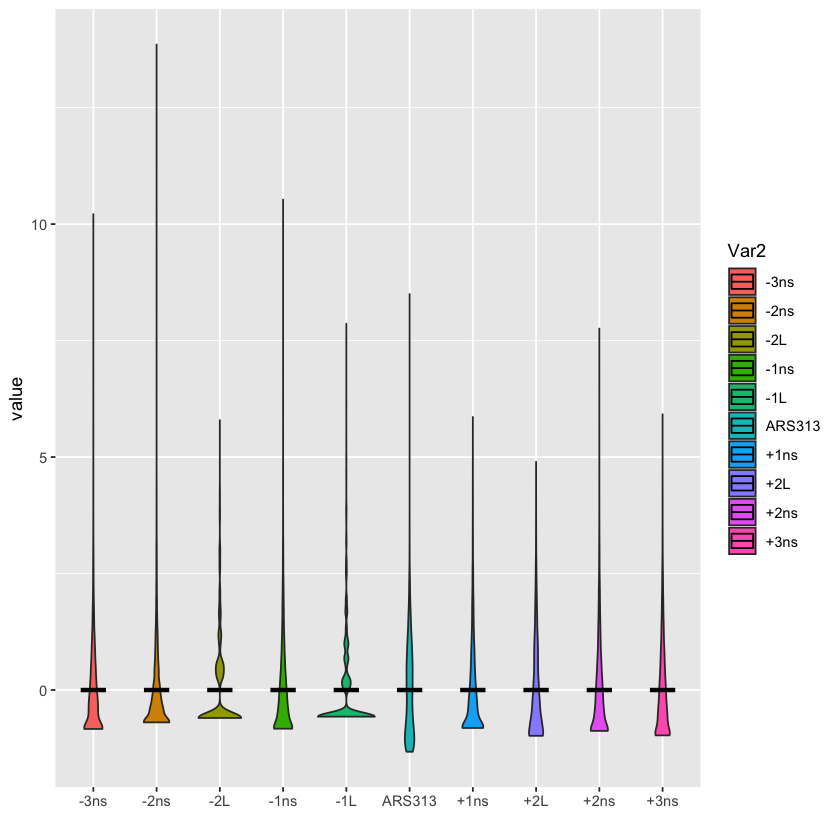

In [362]:
scaled_meth.melt <- melt(scaled_meth)

ggplot(scaled_meth.melt, aes(x = Var2, y = value, fill = Var2)) + 
geom_violin() + 
xlab("") + 
stat_summary(fun = "mean", geom = "crossbar", color = "black", width = 0.4)

In [320]:
#compute distance matrix
d <- dist(scaled_meth, method = "euclidean")

#perform hierarchical clustering using Ward's method
final_clust <- hclust(d, method = "ward.D2" )

#cut the dendrogram into 4 clusters
groups <- cutree(final_clust, k=4)
#groups <- cutreeDynamic(corr_clust, distM= as.matrix(d),
#                             method="hybrid", deepSplit = 0.05)

#find number of observations in each cluster
table(groups)

groups
   1    2    3    4 
 311 2204 5363  906 

In [321]:
aggr_data <- cbind(methylation_long, groups)

In [322]:
umap_scaled <- umap(scaled_meth, metric= "euclidean")

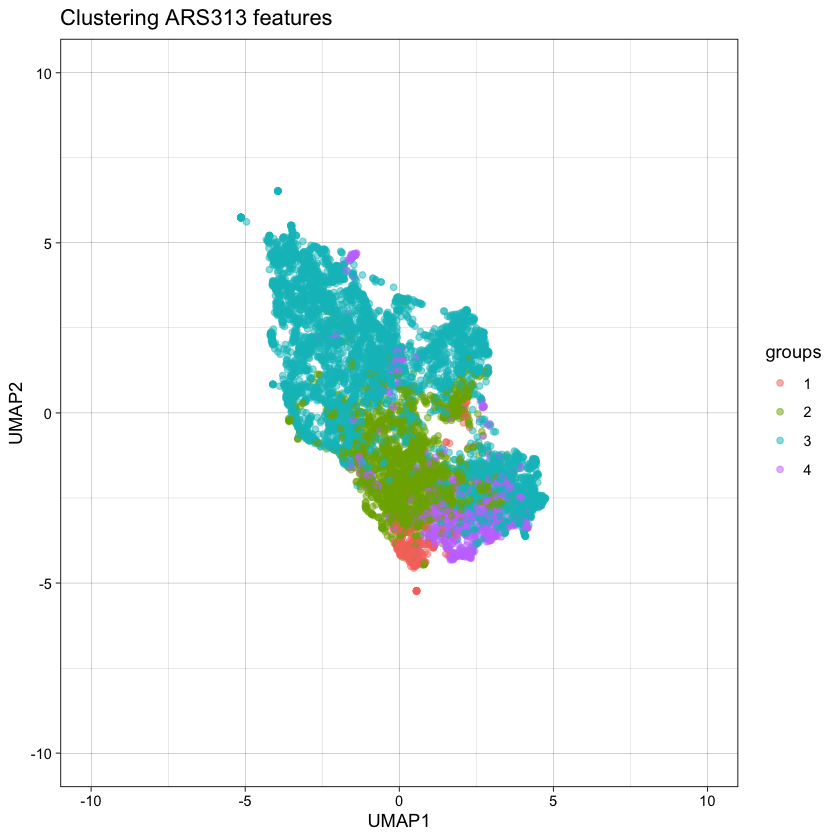

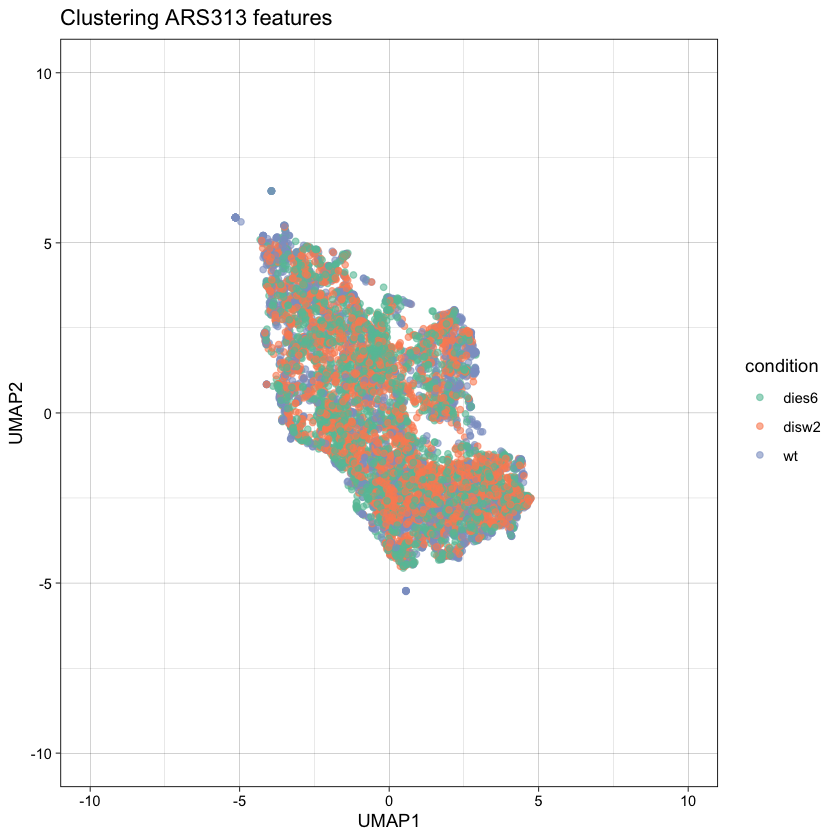

In [323]:
plot_data <- cbind(umap_scaled, aggr_data)
plot_data$groups <- factor(plot_data$groups)

colnames(plot_data)[1:2] = c("UMAP1", "UMAP2")

ggplot(plot_data, aes(x = UMAP1, y = UMAP2, color= groups)) + 
  theme_linedraw() + 
  geom_point(alpha = 0.5) +
  labs(title = "Clustering ARS313 features") +
  scale_x_continuous(limits = c(-10,10)) +
  scale_y_continuous(limits = c(-10, 10))

ggplot(plot_data, aes(x = UMAP1, y = UMAP2, color= condition)) + 
  theme_linedraw() + 
  geom_point(alpha=0.6) +
  scale_color_brewer(type = "qual", palette = "Set2") +
  labs(title = "Clustering ARS313 features") +
  scale_x_continuous(limits = c(-10,10)) +
  scale_y_continuous(limits = c(-10, 10))

In [324]:
#set.seed(43)
#k <- kmeans(scaled_meth, centers= 2,
#            nstart = 10)  
## number of data points in each cluster
#table(k$cluster)

#quality of partition as Between sum of squares / total sum of squares
#100 * k$betweenss/k$totss

#sil <- silhouette(k$cluster, dist(scaled_meth))
#fviz_silhouette(sil) +
#  scale_fill_brewer(type = "qual", palette = "Set2")

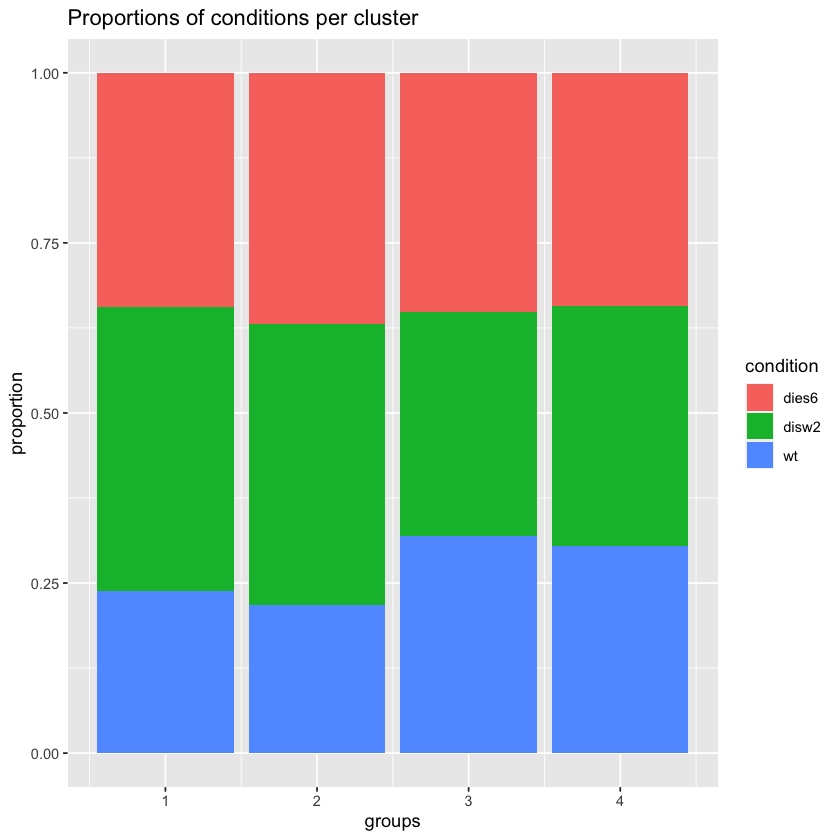

In [325]:
ggplot(data = aggr_data, aes(x = groups, fill = condition)) +
  geom_bar(position = "fill") + ylab("proportion") + 
  ggtitle("Proportions of conditions per cluster")

In [326]:
aggr_data$groups <- as.factor(aggr_data$groups)

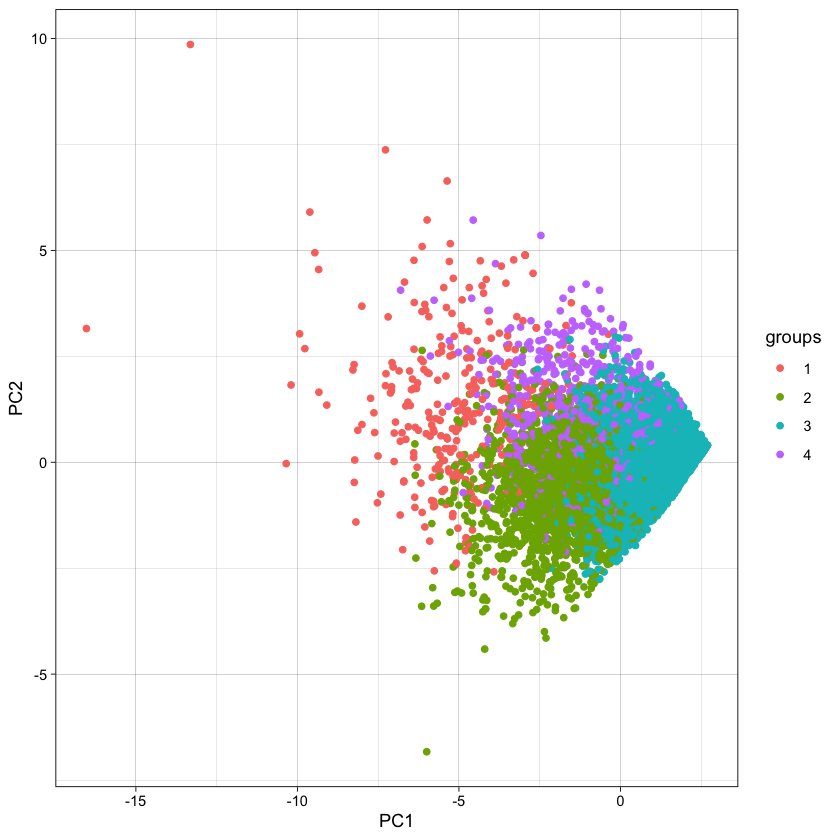

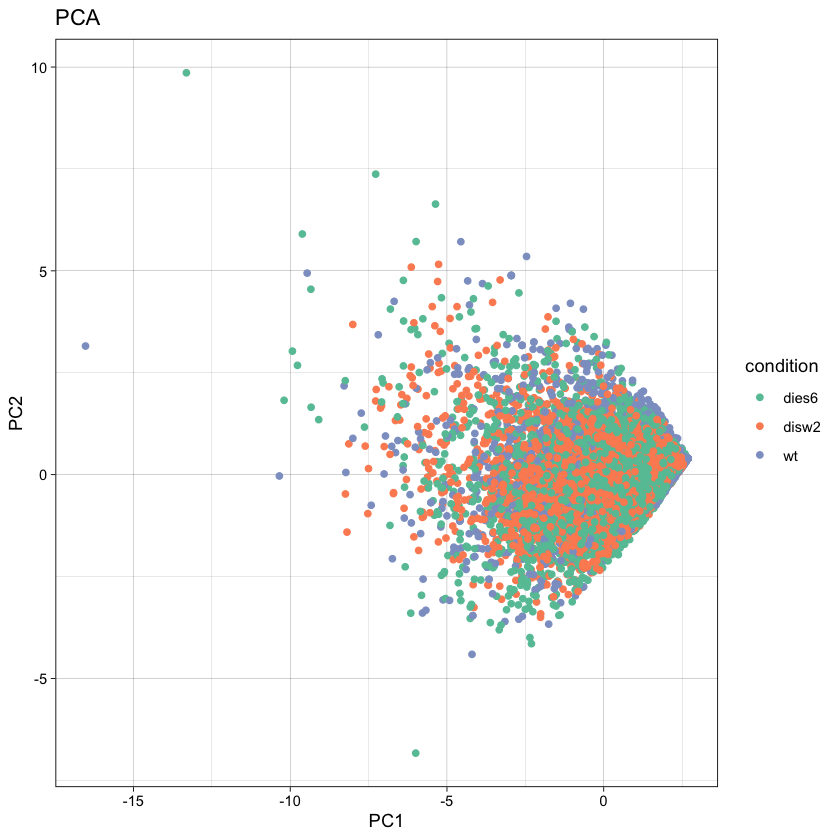

In [327]:
plot_pc_aggr_data <- cbind(pca_meth$x[,1:2], aggr_data)

ggplot(plot_pc_aggr_data) + 
theme_linedraw() + 
geom_point(aes(x = PC1, y = PC2, color = groups)) 

ggplot(plot_pc_aggr_data, aes(x = PC1, y = PC2, color= condition)) + 
  theme_linedraw() + 
  geom_point() +
  scale_color_brewer(type = "qual", palette = "Set2") +
  labs(title = "PCA")

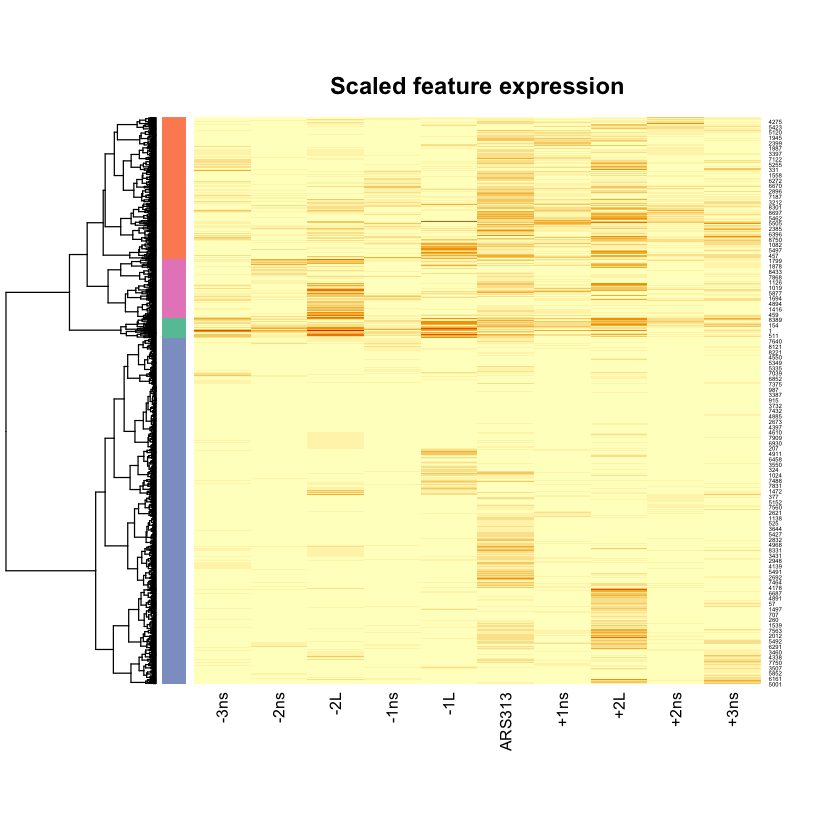

In [328]:
#aggr_data

col1 <- brewer.pal(6, "Set2")

heatmap(as.matrix(aggr_data[,3:12]), Colv=NA, Rowv= as.dendrogram(final_clust), scale = "none",
       main = "Scaled feature expression", RowSideColors = col1[groups]
       )

In [329]:
cor_mat <- cor(t(scaled_meth),method="spearman")
dissim_mat <- sqrt((1-cor_mat)/2)
dist_mat <- as.dist(dissim_mat)
corr_clust <- hclust(dist_mat, method="ward.D2")

#cut the dendrogram into 4 clusters
corr_groups <- cutree(corr_clust, k=5)
#corr_groups <- cutreeDynamic(corr_clust, distM=as.matrix(dissim_mat),
#                             method="hybrid", deepSplit = 0.05)

#find number of observations in each cluster
table(corr_groups)

corr_groups
   1    2    3    4    5 
1994 1194 1530 2180 1886 

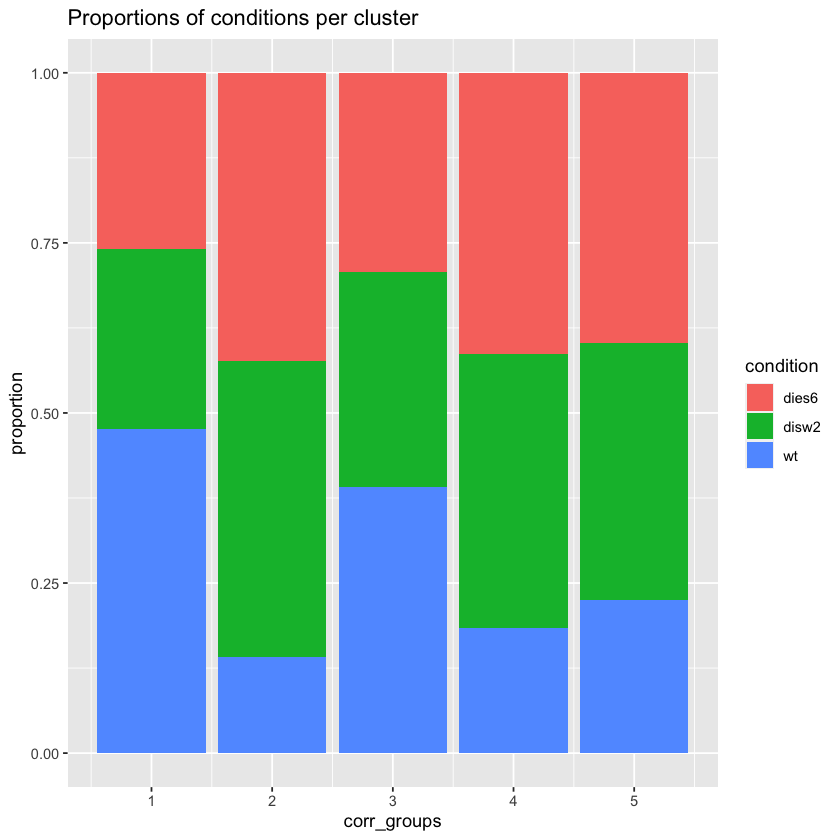

In [330]:
aggr_corr_data <- cbind(methylation_long, corr_groups)

ggplot(data = aggr_corr_data, aes(x = corr_groups, fill = condition)) +
  geom_bar(position = "fill") + ylab("proportion") + 
  ggtitle("Proportions of conditions per cluster")

In [331]:
umap_corr <- umap(scaled_meth, metric = "correlation")

In [332]:
colnames(umap_corr) <- c("UMAP1", "UMAP2")

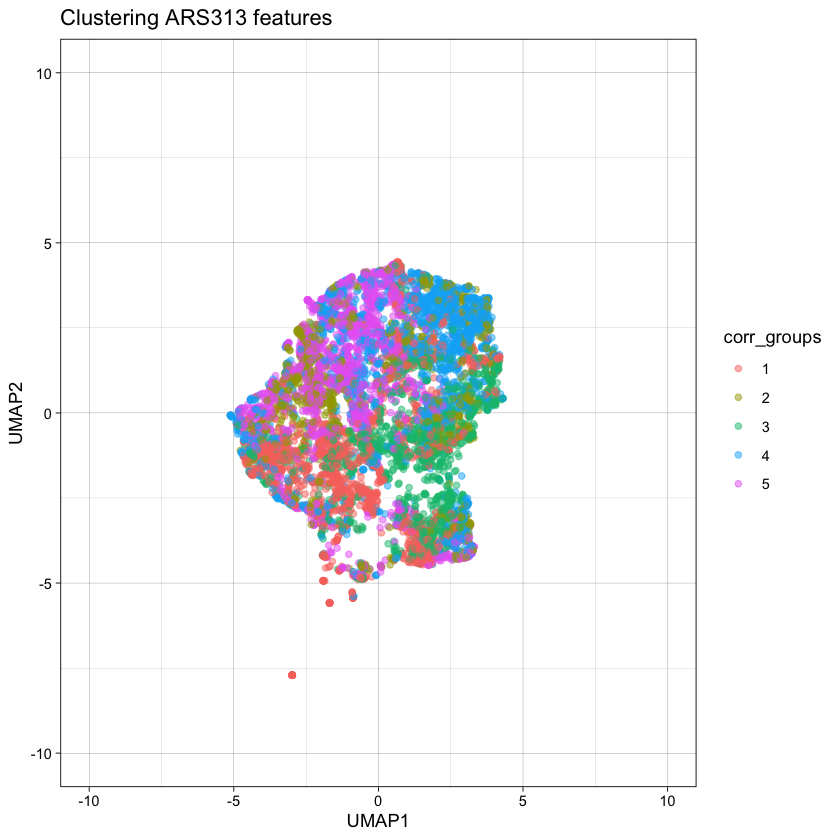

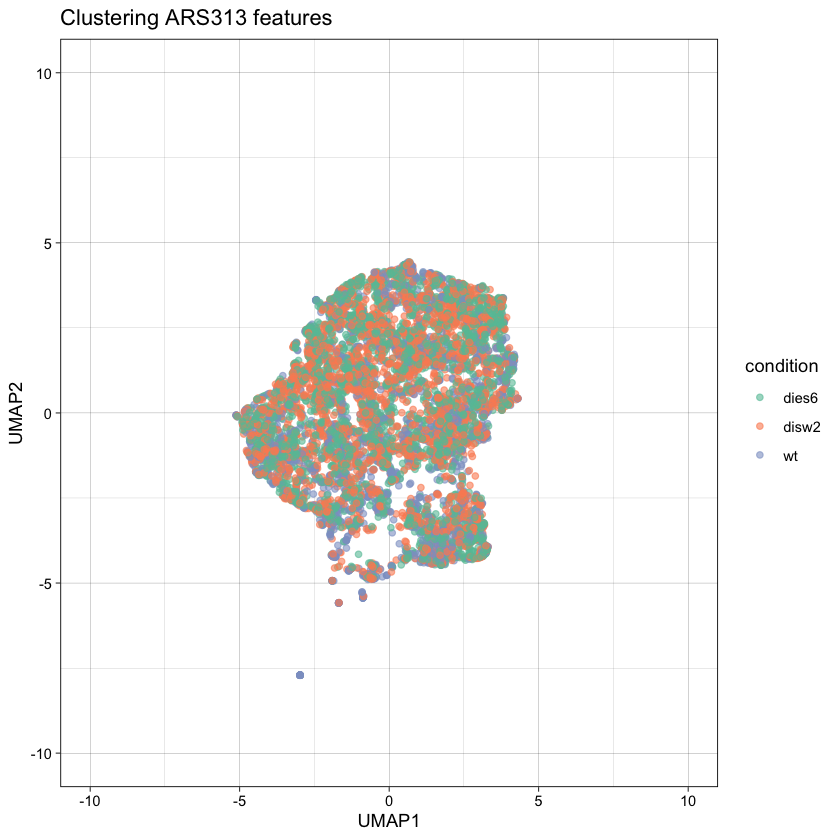

In [333]:
corr_plot_data <- cbind(umap_corr, aggr_corr_data)
corr_plot_data$corr_groups <- factor(corr_plot_data$corr_groups)

colnames(corr_plot_data)[1:2] = c("UMAP1", "UMAP2")

ggplot(corr_plot_data, aes(x = UMAP1, y = UMAP2, color= corr_groups)) + 
  theme_linedraw() + 
  geom_point(alpha = 0.5) +
  labs(title = "Clustering ARS313 features") +
  scale_x_continuous(limits = c(-10,10)) +
  scale_y_continuous(limits = c(-10, 10))

ggplot(corr_plot_data, aes(x = UMAP1, y = UMAP2, color= condition)) + 
  theme_linedraw() + 
  geom_point(alpha=0.6) +
  scale_color_brewer(type = "qual", palette = "Set2") +
  labs(title = "Clustering ARS313 features") +
  scale_x_continuous(limits = c(-10,10)) +
  scale_y_continuous(limits = c(-10, 10))

In [352]:
for( i in 1:ncol(scaled_meth)){
    print(range(scaled_meth[,i]))
    }
colMeans(scaled_meth)

aggr_corr_data$condition

[1] -0.8358625 10.2128613
[1] -0.6940986 13.8544679
[1] -0.6000303  5.7917928
[1] -0.8299858 10.5262194
[1] -0.5716751  7.8627321
[1] -1.325327  8.498028
[1] -0.8147586  5.8596464
[1] -0.9830525  4.8981990
[1] -0.8768974  7.7571478
[1] -0.9732435  5.9179722


-3ns          -2ns           -2L          -1ns           -1L 
-2.527040e-17  1.185078e-17  6.866219e-17  6.029490e-17  1.061373e-17 
       ARS313          +1ns           +2L          +2ns          +3ns 
-1.160219e-16 -6.532071e-17  5.276846e-18 -5.585162e-17  3.578776e-17

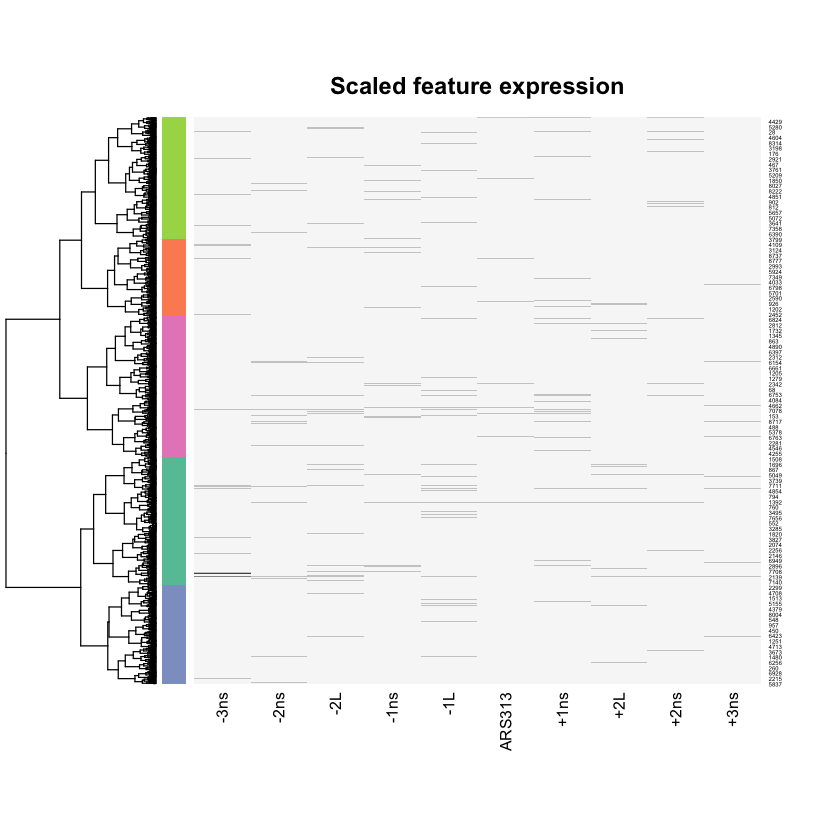

In [372]:
col <- brewer.pal(10, "RdYlBu")
col1 <- brewer.pal(6, "Set2")
col2 <- brewer.pal(4, "Greys")
col3 <- c("#ffffff", "#9fc5e8", "#16537e")

heatmap(scaled_meth, Colv=NA, Rowv= as.dendrogram(corr_clust),
        scale = "none",
        main = "Scaled feature expression",
        col = col2,
        RowSideColors = col1[corr_groups]
       )

In [443]:
brewer.pal(5, "Dark2")
brewer.pal(5, "Set2")
brewer.pal(9, "Set1")

col_Anna = ["black", "#0a22fa", "#f2180c"]

[1] "#1B9E77" "#D95F02" "#7570B3" "#E7298A" "#66A61E"

[1] "#66C2A5" "#FC8D62" "#8DA0CB" "#E78AC3" "#A6D854"

[1] "#E41A1C" "#377EB8" "#4DAF4A" "#984EA3" "#FF7F00" "#FFFF33" "#A65628"
[8] "#F781BF" "#999999"

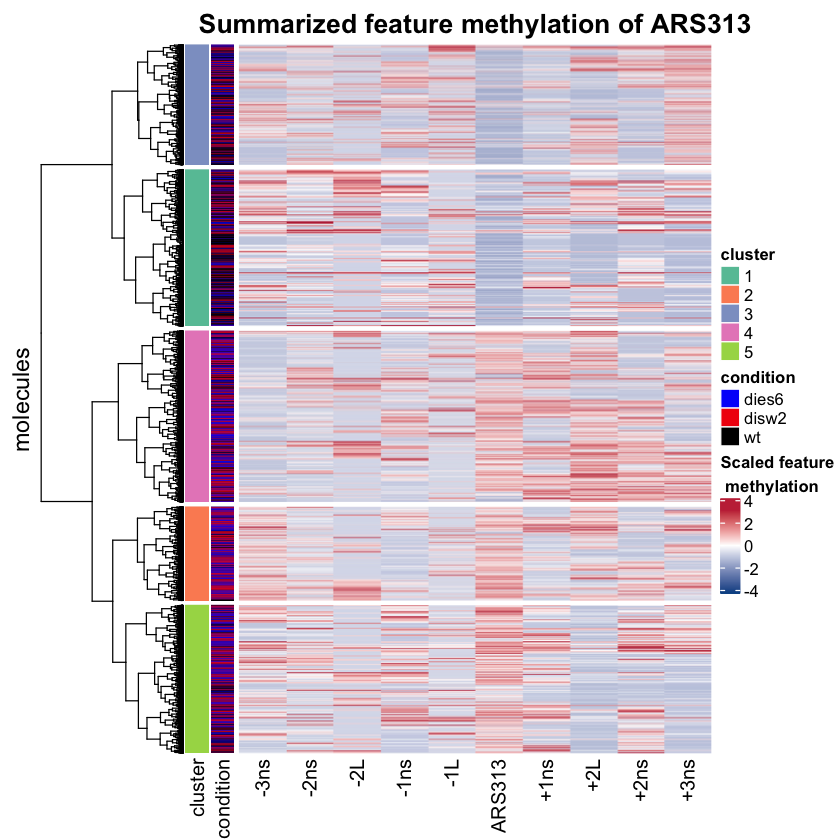

In [444]:
num_cluster <- length(unique(corr_groups))

col_list <- list(cluster = c("1" = '#66C2A5', "2" = '#FC8D62', "3" = '#8DA0CB', "4" = '#E78AC3', "5" = '#A6D854'),
                 condition = c("wt" = "black", "dies6" = "#0a22fa", "disw2" = "#f2180c"))
#Heatmap annotation
ha <- rowAnnotation(
    cluster = corr_groups, 
    condition = aggr_corr_data$condition, #insert replicate ?
    col = col_list 
)


color_func <- colorRamp2(c(-4,0,3), c("#0b5394", "white", "#c53145"))

Heatmap(scaled_meth, name = "Scaled feature \n methylation", #title of legend
       row_title = "molecules",
       show_row_names = FALSE,
        row_split = num_cluster,
        cluster_columns = FALSE,
        cluster_rows = as.dendrogram(corr_clust), row_dend_width = unit(3, "cm"),
        width = unit(10, "cm"), height = unit(15, "cm"),
        col = color_func, 
        column_title = "Summarized feature methylation of ARS313", column_title_gp = gpar(fontsize = 16, fontface = "bold"),
        left_annotation = ha
       )

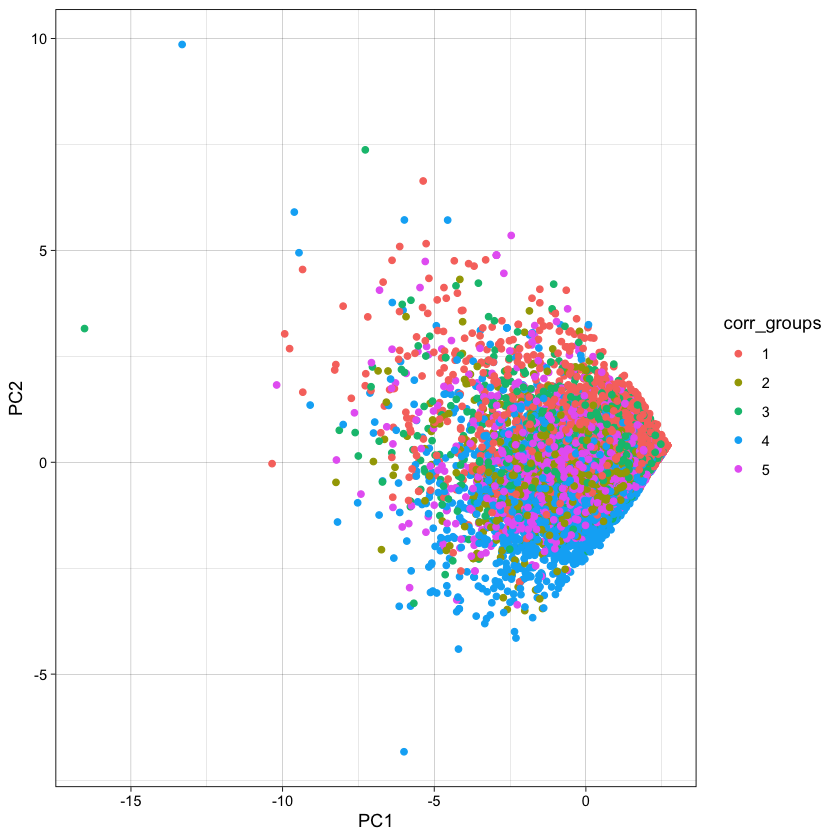

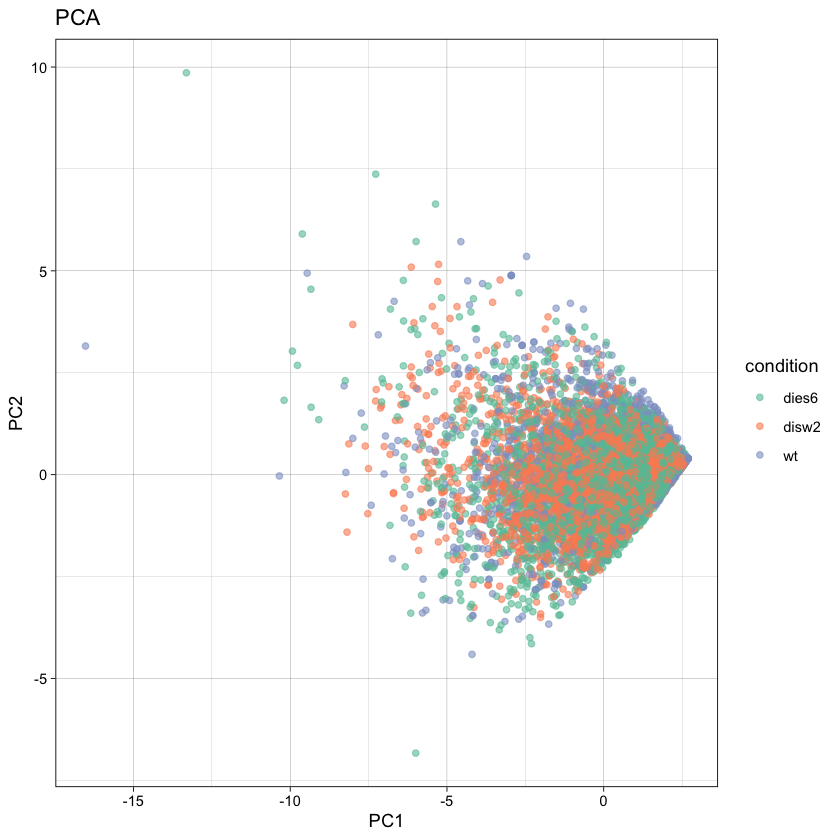

In [335]:
aggr_corr_data$corr_groups <- as.factor(aggr_corr_data$corr_groups)

plot_pc_aggr_data <- cbind(pca_meth$x[,1:2], aggr_corr_data)

ggplot(plot_pc_aggr_data) + 
theme_linedraw() + 
geom_point(aes(x = PC1, y = PC2, color = corr_groups)) 

ggplot(plot_pc_aggr_data, aes(x = PC1, y = PC2, color= condition)) + 
  theme_linedraw() + 
  geom_point(alpha=0.6) +
  scale_color_brewer(type = "qual", palette = "Set2") +
  labs(title = "PCA")